In [7]:
import pandas_datareader.data as pdr
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

In [8]:
import sys
from pathlib import Path

HERE = Path('.').absolute().parent
sys.path.append(str(HERE))

In [9]:
from efficient_frontier import data

In [10]:
def drop_outliers(df: pd.DataFrame, border_sigma: int = 5) -> pd.DataFrame:
    mean = df.mean()
    std = df.std()
    up_bound = mean + std * border_sigma
    btm_bound = mean - std * border_sigma
    mask = (df < btm_bound) | (df > up_bound)
    return df[~mask.any(axis=1)]

In [11]:
def get_rand_weights(n_samples: int = 100, n_weights: int = 3, seed: int = 7) -> np.ndarray:
    alpha = np.ones(n_weights)
    rng = np.random.default_rng(seed)
    return rng.dirichlet(alpha, n_samples)

In [12]:
def log_to_simple_return(val: np.ndarray, percent: bool = True) -> np.ndarray:
    mul_val = 100 if percent else 1
    return (np.exp(val) - 1) * mul_val

In [13]:
# yf.pdr_override()

In [14]:
DAYS = 251

In [15]:
start = dt.datetime(2016, 1, 1)
end = dt.date.today()
# end = dt.datetime(2020, 12, 31)

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

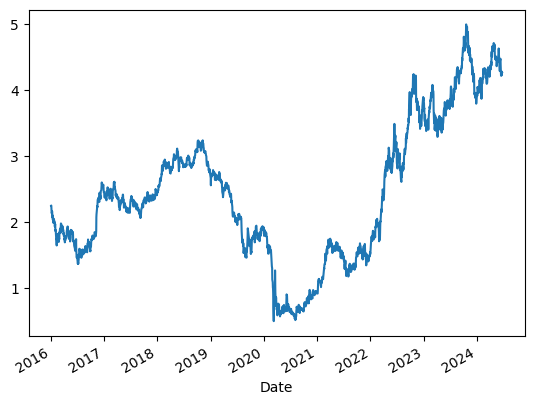

In [16]:
df_risk_free = yf.download(
    tickers="^TNX",
    start=start,
    end=end,
)['Close']
df_risk_free.plot()

In [ ]:
MEAN_RISK_FREE = df_risk_free.mean() * 0.01
MEAN_RISK_FREE

In [ ]:
sr_usd_jpy = yf.download(
    tickers="JPY=X",
    start=start,
    end=end,
)['Close']
sr_usd_jpy

In [ ]:
ticker = '1321'
ticker_jp = ticker + '.JP'
pdr.DataReader(ticker_jp, 'stooq', start, end)

In [ ]:
pdr.DataReader('IRLTLT01JPM156N', 'fred', start, end).plot()

In [ ]:
# symbols = ["QQQ", "GLD", "DIA", "BND"]
symbols = ["QQQ", "GLD", "DIA"]
# symbols = ["QQQ", "GLD"]

raw_df = yf.download(tickers=symbols, start=start, end=end, actions=True)
raw_df.ffill(inplace=True)
df_close = raw_df['Close']
df_close = df_close[symbols]
df_dividends = raw_df['Dividends']
df_dividends = df_dividends[symbols]

In [ ]:
df_dividends.sum(axis=0)

In [ ]:
px.line(df_close)

In [ ]:
_shift = df_close.shift()
_shift.iloc[0, :] = _shift.iloc[1, :]
df_log_return = np.log(df_close / _shift)
df_log_return = drop_outliers(df_log_return)
# np.log((df_close + df_dividends) / _shift)
df_ret = pd.DataFrame([df_log_return.mean() * DAYS], index=['capital'])
np.exp(df_ret)

In [ ]:
_ret_income = np.log((df_dividends + df_close) / df_close).mean(axis=0) * DAYS
df_ret = pd.concat([df_ret, pd.DataFrame([_ret_income], index=['income'])])
df_ret = pd.concat([df_ret, pd.DataFrame([df_ret.iloc[0, :] + df_ret.iloc[1, :]], index=['total'])])
df_ret

In [ ]:
df_ret.T

In [ ]:
np.exp(df_ret)

In [ ]:
df_cov = df_log_return.cov() * DAYS
df_cov

In [ ]:
weights = get_rand_weights(n_samples=5000, n_weights=len(df_cov))
weights

In [ ]:
df_weights = pd.DataFrame(weights, columns=df_cov.columns)
df_weights

In [ ]:
ret_list = weights @ df_ret.loc['total'].to_numpy().squeeze()
std_list = np.sqrt(((weights @ df_cov.to_numpy()) * weights).sum(axis=1))
ret_list[:5], std_list[:5]

In [ ]:
pd.DataFrame({"return": ret_list, "std": std_list})

In [ ]:
ret_each = pd.DataFrame([df_ret.loc['total'].to_numpy().squeeze(), np.sqrt(np.diagonal(df_cov))], columns=df_ret.columns, index=['ret', 'risk'])
ret_each

In [ ]:
MEAN_RISK_FREE

In [ ]:
sharp_ratio = (log_to_simple_return(ret_list, percent=False) - MEAN_RISK_FREE) / std_list
sharp_ratio

In [ ]:
hover_text_weights_label = [f'{x}: ' + '%{customdata[' + str(i) + ']:.2f}' for i, x in enumerate(df_cov.columns)]
hover_text_weights = "<br>".join(hover_text_weights_label)
hover_text_weights

In [ ]:
scatters = go.Scatter(
    x=std_list * 100,
    y=log_to_simple_return(ret_list),
    customdata=df_weights,
    mode='markers',
    name='',
    # text=f'Return : {std_list * 100}<br>Risk',
    hoverinfo='text',
    hovertemplate=hover_text_weights + '<br><br>Return: %{y:.1f}<br>Risk: %{x:.1f}<br>Sharpe Ratio: %{marker.color:.2f}<br>',
    marker=dict(
        size=4,
        color=sharp_ratio,
        colorscale='Viridis',
        colorbar=dict(title='Sharpe Ratio', len=0.5, yanchor='bottom', y=0),
        opacity=1,
    ),
)


asset_points = [
    go.Scatter(
        x=[row[1]['risk'] * 100],
        y=[log_to_simple_return(row[1]['ret'])],
        mode='markers+text',
        text=row[0],
        textposition='top right',
        name=row[0],
        hoverinfo='text',
        hovertemplate=row[0] + '<br><br>Return: %{y:.1f}<br>Risk: %{x:.1f}',
        marker=dict(
            symbol="diamond",
        ),
        # marker=dict(size=3, color=samples[:, 2], colorscale='Viridis', opacity=0.3),
    )
    for row in ret_each.T.iterrows()
]

layout = go.Layout(
    xaxis={'title': 'Risk (%)'},
    yaxis={
        'title': 'Return (%)',
    },
)

fig = go.Figure(layout=layout)

fig.add_trace(scatters)
# fig.add_trace(asset_points)
fig.add_traces(asset_points)
fig.update_layout(width=800, height=800)
fig.show()